In [203]:
# !pip install langgraph-supervisor
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
from langchain_core.tools import tool
from langchain.tools import Tool
from functools import partial
from langgraph.prebuilt import create_react_agent, ToolNode
from langgraph.checkpoint.memory import MemorySaver
from langgraph.store.memory import InMemoryStore
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import HumanMessage
from langgraph_supervisor import create_supervisor
import pandas as pd
import uuid

## Set Open AI API Key

In [3]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

In [4]:
model = ChatOpenAI(model="o3-mini")

## Mock Data

In [181]:
#  Flight Schedule 
flight_schedule_df = pd.DataFrame([
    {
        "flight_id": "UA123",
        "origin": "ORD",
        "destination": "SFO",
        "sched_dep": "2024-08-10 08:00",
        "sched_arr": "2024-08-10 11:00",
        "aircraft_type": "B737",
        "delay_minutes": 210,  # 3.5 hr delay
        "status": "delayed",
        "gate": "C5",
        "remarks": "ground stop"
    },
    {
        "flight_id": "UA456",
        "origin": "SFO",
        "destination": "DEN",
        "sched_dep": "2024-08-10 12:00",
        "sched_arr": "2024-08-10 14:00",
        "aircraft_type": "B737",
        "delay_minutes": 0,
        "status": "ontime",
        "gate": "B12",
        "remarks": ""
    }
])

#  Crew Roster 
crew_roster_df = pd.DataFrame([
    {
        "crew_id": "C001",
        "name": "Jane Doe",
        "role": "captain",
        "base": "ORD",
        "qualified_aircraft": "B737",
        "assigned_flight_id": "UA123",
        "duty_start": "2024-08-10 07:00",
        "duty_end": "2024-08-10 15:00",
        "rest_until": "2024-08-10 23:00",
        "status": "active"
    },
    {
        "crew_id": "C002",
        "name": "John Roe",
        "role": "FO",
        "base": "ORD",
        "qualified_aircraft": "B737",
        "assigned_flight_id": "UA123",
        "duty_start": "2024-08-10 07:00",
        "duty_end": "2024-08-10 15:00",
        "rest_until": "2024-08-10 23:00",
        "status": "active"
    },
    {
        "crew_id": "C010",
        "name": "Sam Lee",
        "role": "FO",
        "base": "SFO",
        "qualified_aircraft": "B737",
        "assigned_flight_id": None,
        "duty_start": None,
        "duty_end": None,
        "rest_until": "2024-08-10 06:00",
        "status": "active"
    },
    {
        "crew_id": "C011",
        "name": "Alex Kim",
        "role": "FO",
        "base": "DEN",
        "qualified_aircraft": "B737",
        "assigned_flight_id": None,
        "duty_start": None,
        "duty_end": None,
        "rest_until": "2024-08-10 04:00",
        "status": "active"
    }
])

#  Hotel Inventory 
hotel_inventory_df = pd.DataFrame([
    {
        "hotel_id": "H001",
        "name": "ORD Airport Hotel",
        "location": "ORD",
        "capacity": 200,
        "available_rooms": 20
    },
    {
        "hotel_id": "H002",
        "name": "ORD Downtown Inn",
        "location": "ORD",
        "capacity": 150,
        "available_rooms": 10
    },
    {
        "hotel_id": "H003",
        "name": "SFO Airport Hotel",
        "location": "SFO",
        "capacity": 100,
        "available_rooms": 5
    },
    {
        "hotel_id": "H004",
        "name": "DEN Airport Hotel",
        "location": "DEN",
        "capacity": 120,
        "available_rooms": 8
    }
])

#  Repositioning Flights 
repositioning_flights_df = pd.DataFrame([
    {
        "flight_id": "UA9001",
        "origin": "DEN",
        "destination": "SFO",
        "sched_dep": "2024-08-10 10:00",
        "sched_arr": "2024-08-10 12:00",
        "seats_available": True
    },
    {
        "flight_id": "UA9002",
        "origin": "DEN",
        "destination": "ORD",
        "sched_dep": "2024-08-10 11:00",
        "sched_arr": "2024-08-10 13:00",
        "seats_available": False
    },
    {
        "flight_id": "UA9003",
        "origin": "SFO",
        "destination": "ORD",
        "sched_dep": "2024-08-10 09:00",
        "sched_arr": "2024-08-10 15:00",
        "seats_available": True
    }
])

crew_duty_logs_df = pd.DataFrame(
[{'crew_id': 'C001',
  'duty_end': '2024-08-01 17:00:00',
  'duty_start': '2024-08-01 08:00:00'},
 {'crew_id': 'C001',
  'duty_end': '2024-08-02 18:00:00',
  'duty_start': '2024-08-02 06:00:00'},
 {'crew_id': 'C001',
  'duty_end': '2024-08-03 18:00:00',
  'duty_start': '2024-08-03 08:00:00'},
 {'crew_id': 'C001',
  'duty_end': '2024-08-04 18:00:00',
  'duty_start': '2024-08-04 06:00:00'},
 {'crew_id': 'C001',
  'duty_end': '2024-08-05 15:00:00',
  'duty_start': '2024-08-05 07:00:00'},
 {'crew_id': 'C001',
  'duty_end': '2024-08-06 16:00:00',
  'duty_start': '2024-08-06 08:00:00'},
 {'crew_id': 'C001',
  'duty_end': '2024-08-07 18:00:00',
  'duty_start': '2024-08-07 08:00:00'},
 {'crew_id': 'C002',
  'duty_end': '2024-08-01 17:00:00',
  'duty_start': '2024-08-01 09:00:00'},
 {'crew_id': 'C002',
  'duty_end': '2024-08-02 17:00:00',
  'duty_start': '2024-08-02 07:00:00'},
 {'crew_id': 'C002',
  'duty_end': '2024-08-03 16:00:00',
  'duty_start': '2024-08-03 07:00:00'},
 {'crew_id': 'C002',
  'duty_end': '2024-08-04 18:00:00',
  'duty_start': '2024-08-04 07:00:00'},
 {'crew_id': 'C002',
  'duty_end': '2024-08-05 16:00:00',
  'duty_start': '2024-08-05 07:00:00'},
 {'crew_id': 'C002',
  'duty_end': '2024-08-06 12:00:00',
  'duty_start': '2024-08-06 06:00:00'},
 {'crew_id': 'C002',
  'duty_end': '2024-08-07 16:00:00',
  'duty_start': '2024-08-07 09:00:00'},
 {'crew_id': 'C010',
  'duty_end': '2024-08-01 17:00:00',
  'duty_start': '2024-08-01 07:00:00'},
 {'crew_id': 'C010',
  'duty_end': '2024-08-02 15:00:00',
  'duty_start': '2024-08-02 09:00:00'},
 {'crew_id': 'C010',
  'duty_end': '2024-08-03 14:00:00',
  'duty_start': '2024-08-03 06:00:00'},
 {'crew_id': 'C010',
  'duty_end': '2024-08-04 20:00:00',
  'duty_start': '2024-08-04 08:00:00'},
 {'crew_id': 'C010',
  'duty_end': '2024-08-05 16:00:00',
  'duty_start': '2024-08-05 07:00:00'},
 {'crew_id': 'C010',
  'duty_end': '2024-08-06 21:00:00',
  'duty_start': '2024-08-06 09:00:00'},
 {'crew_id': 'C010',
  'duty_end': '2024-08-07 18:00:00',
  'duty_start': '2024-08-07 07:00:00'}]
)

transport_df = pd.DataFrame([
    {
        "from_location": "Downtown Marriott",
        "to_location": "SFO",
        "mode": "cab",
        "eta_minutes": 45,
        "available_vehicles": 3
    },
    {
        "from_location": "Union Square Hotel",
        "to_location": "ORD",
        "mode": "shuttle",
        "eta_minutes": 30,
        "available_vehicles": 2
    },
    {
        "from_location": "ORD",
        "to_location": "ORD Airport Hotel",
        "mode": "shuttle",
        "eta_minutes": 30,
        "available_vehicles": 2
    },
    {
        "from_location": "Central Train Station",
        "to_location": "DEN",
        "mode": "train",
        "eta_minutes": 120,
        "available_vehicles": 5
    },
    {
        "from_location": "Airport Terminal 3",
        "to_location": "SFO",
        "mode": "shuttle",
        "eta_minutes": 20,
        "available_vehicles": 4
    },
    {
        "from_location": "Convention Center",
        "to_location": "ORD",
        "mode": "cab",
        "eta_minutes": 60,
        "available_vehicles": 1
    }
])

duty_rules = {
    "max_duty_hours":     8.0,
    "min_rest_hours":    10.0,
    "aircraft_type":    "B737"
    # "crew_duty_logs_df":  crew_duty_logs_df,
    # "crew_roster_df":     crew_roster_df
}

## Setting up short-term and long-term memory

In [182]:
in_memory_store = InMemoryStore()
checkpointer = MemorySaver()

## State

In [183]:
from typing_extensions import TypedDict
from typing import Annotated, List
from langgraph.graph.message import AnyMessage, add_messages
from langgraph.managed.is_last_step import RemainingSteps

class State(TypedDict):
    flight_id: str
    messages: Annotated[list[AnyMessage], add_messages]
    loaded_memory: str
    remaining_steps: RemainingSteps 

## Mock Tools

### Crew Assignment Agent Tools

In [184]:
@tool
def query_flight_status(flight_id, flight_schedule_df = flight_schedule_df):

    """
    Return status information for the given flight ID.

    Args:

    flight_id (str): Flight identifier.

    flight_schedule_df (DataFrame): Flight schedule data source.

    Returns:

    dict: { flight_id, status, delay_minutes, gate, remarks, aircraft_type }

    """

    if flight_id is None:
        raise ValueError("Please provide flight_schedule_df")
        
    cols = ['flight_id', 'status', 'delay_minutes', 'gate', 'remarks', 'aircraft_type']
    filtered = flight_schedule_df[flight_schedule_df['flight_id'] == flight_id][cols]
    result = filtered.to_dict(orient = 'records')

    return result[0] if result else None

    pass


@tool
def query_crew_roster(flight_id=None, crew_id=None, crew_roster_df=crew_roster_df):

    """

    Fetch assigned crew for a flight or details for a specific crew member.

    Args:

    flight_id (str, optional): Flight identifier.

    crew_id (str, optional): Crew identifier.

    crew_roster_df (DataFrame): Crew data source.

    Returns:

    list of dicts or dict: Crew details.

    """
    if crew_roster_df is None:
        raise ValueError("Please provide `crew_roster_df`")

    df = crew_roster_df.copy()

    if flight_id is not None and crew_id is not None:
        raise ValueError("Please supply one of flight_id or crew_id")
    elif flight_id is not None:
        return df[df['assigned_flight_id'] == flight_id].to_dict(orient='records')
    elif crew_id is not None:
        result = df[df['crew_id'] == crew_id].to_dict(orient = 'records')
        return result[0] if result else None
    else:
        raise ValueError("Please supply flight id or crew id")

    return result

    pass

@tool
def find_connecting_flight(flight_id: str,
                           flight_schedule_df = flight_schedule_df,
                           min_layover_minutes: int = 30) -> dict:
    """
    Given a flight_id, find the next flight departing from that flight's destination
    at least `min_layover_minutes` after its scheduled arrival.
    """
    import pandas as pd

    df = flight_schedule_df.copy()
    cur = df[df.flight_id == flight_id]
    if cur.empty:
        return {"error": "flight not found"}
    cur = cur.iloc[-1]
    arr_time = pd.to_datetime(cur.sched_arr) + pd.Timedelta(minutes=min_layover_minutes)
    dest    = cur.destination

    cand = df[
        (df.origin == dest) &
        (pd.to_datetime(df.sched_dep) >= arr_time)
    ]
    if cand.empty:
        return {"error": "no connecting flights found"}

    nxt = cand.sort_values("sched_dep").iloc[0]
    return nxt.to_dict()


@tool
def query_spare_pool(
    flight_id: str,
    role: str
) -> list[dict]:
    """
    Given a flight_id and crew role (e.g. "captain" or "FO"), find all
    unassigned, qualified, rested crew for the *connecting* flight.
    """
    import pandas as pd
    # bring in your globals
    fs_df   = flight_schedule_df
    roster  = crew_roster_df

    # 1) find the connecting flight
    conn = find_connecting_flight(flight_id)
    if "error" in conn:
        return []
    location      = conn["origin"]
    aircraft_type = conn["aircraft_type"]
    sched_dep     = pd.to_datetime(conn["sched_dep"])

    # 2) filter your roster
    roster = roster.copy()
    roster["rest_until"] = pd.to_datetime(roster["rest_until"])
    conds = (
        roster.assigned_flight_id.isna() &
        (roster.base == location) &
        (roster.qualified_aircraft == aircraft_type) &
        (roster.role == role) &
        roster.rest_until.le(sched_dep) &
        (roster.status == "active")
    )
    return roster.loc[conds].to_dict(orient="records")


@tool
def duty_hour_checker(crew_id, 
                      planned_start, 
                      planned_end, 
                      duty_rules = duty_rules, 
                      crew_duty_logs_df = crew_duty_logs_df, 
                      crew_roster_df = crew_roster_df):

    """

    Check legality of crew duty period.

    Args:

    crew_id (str)

    planned_start (datetime)

    planned_end (datetime)

    duty_rules (dict)

    crew_duty_logs_df (Dataframe): Crew duty logs

    crew_roster_df (DataFrame): Crew data source.

    Returns:

    dict: { legal: bool, reason: str if not legal }

    """

    max_duty   = duty_rules["max_duty_hours"]
    min_rest   = duty_rules["min_rest_hours"]
    flight_ac  = duty_rules["aircraft_type"]
    logs_df    = crew_duty_logs_df
    roster_df  = crew_roster_df

    planned_start = pd.to_datetime(planned_start)
    planned_end   = pd.to_datetime(planned_end)

    qual = roster_df.loc[roster_df["crew_id"] == crew_id, "qualified_aircraft"]
    if qual.empty or qual.iloc[0] != flight_ac:
        return {"legal": False, "reason": f"Not qualified for {flight_ac}"}

    logs_df = logs_df.copy()
    logs_df["duty_start"] = pd.to_datetime(logs_df["duty_start"])
    logs_df["duty_end"]   = pd.to_datetime(logs_df["duty_end"])

    past = logs_df[
        (logs_df["crew_id"] == crew_id) &
        (logs_df["duty_end"] <= planned_start)
    ]
    if not past.empty:
        last_end = past["duty_end"].max()
        rest_hrs = (planned_start - last_end).total_seconds() / 3600.0
        if rest_hrs < min_rest:
            return {
                "legal": False,
                "reason": f"Only {rest_hrs:.1f}h rest (<{min_rest}h required)"
            }

    # 2) Max‐duty‐hours check
    duty_hrs = (planned_end - planned_start).total_seconds() / 3600.0
    if duty_hrs > max_duty:
        return {
            "legal": False,
            "reason": f"{duty_hrs:.1f}h duty (> {max_duty}h limit)"
        }

    # passed all checks
    return {"legal": True}


    pass


@tool
def reposition_flight_finder(from_location, to_location, repositioning_flights_df = repositioning_flights_df):

    """

    Find repositioning flight options for crew.

    Args:

    from_location (str)

    to_location (str)

    repositioning_flights_df (DataFrame)

    Returns:

    list of dicts: Flight options.

    """

    if repositioning_flights_df is None:
        raise ValueError("Please provide `repositioning_flights_df`")
    if not (from_location and to_location):
        raise ValueError("Please supply both from_location and to_location")

    df = repositioning_flights_df.copy()

    for col in ("sched_dep", "sched_arr"):
        if col in df.columns:
            df[col] = pd.to_datetime(df[col])

    conditions = (
        (df["origin"] == from_location) &
        (df["destination"] == to_location) &
        (df["seats_available"] == True)
    )
    

    filtered = df.loc[conditions].sort_values(by="sched_dep")

    # Convert to list of dicts
    return filtered.to_dict(orient="records")

    pass

### Ops Agent Tools

In [185]:
@tool
def book_hotel(location, hotel_inventory_df = hotel_inventory_df):

    """

    Attempt to book hotel for crew.

    Args:

    location (str)

    hotel_inventory_df (DataFrame)

    Returns:

    dict: { success: bool, hotel_name or failure_reason }

    """

    if hotel_inventory_df is None:
        raise ValueError("Please provide `hotel_inventory_df`")

    # Find all hotels at the location with rooms available
    mask = (
        (hotel_inventory_df["location"] == location) &
        (hotel_inventory_df["available_rooms"] > 0)
    )
    candidates = hotel_inventory_df.loc[mask]

    if candidates.empty:
        return {
            "success": False,
            "failure_reason": f"No rooms available at {location}"
        }

    # Choose the hotel with the most available rooms
    chosen_idx = candidates["available_rooms"].idxmax()
    chosen_hotel_id = hotel_inventory_df.loc[chosen_idx, "hotel_id"]
    chosen_hotel_name = hotel_inventory_df.loc[chosen_idx, "name"]

    # Decrement inventory
    hotel_inventory_df.at[chosen_idx, "available_rooms"] -= 1

    return {
        "success": True,
        "hotel_name": chosen_hotel_name
    }

    pass


@tool
def arrange_transport(from_location, to_location):

    """

    Arrange transport for crew.

    Args:

    from_location (str)

    to_location (str)

    Returns:

    dict: { success: bool, eta or failure_reason }

    """

    # Filter matching routes with available vehicles
    available = transport_df[
        (transport_df["from_location"]  == from_location)   &
        (transport_df["to_location"]  == to_location)   &
        (transport_df["available_vehicles"] > 0)
    ]
    if available.empty:
        return {
            "success": False,
            "failure_reason": f"No transport available from {from_location} to {to_location}"
        }
    
    # Choose the fastest option
    best_idx = available["eta_minutes"].idxmin()
    best_option = transport_df.loc[best_idx]
    
    # Decrement availability
    transport_df.at[best_idx, "available_vehicles"] -= 1
    
    return {
        "success": True,
        "eta_minutes": best_option["eta_minutes"],
        "mode": best_option["mode"]
    }

    pass

## Collect All Tools

In [186]:
crew_tools = [
    query_flight_status,
    query_crew_roster,
    query_spare_pool,
    duty_hour_checker,
    find_connecting_flight
]

ops_tools = [book_hotel, arrange_transport]

# llm_with_crew_tools = model.bind_tools(crew_tools)
# llm_with_ops_tools = model.bind_tools(ops_tools)

In [187]:
# crew_tool_node = ToolNode(crew_tools)
# ops_tool_node = ToolNode(ops_tools)

## Create React Agent

In [188]:
crew_assignment_prompt = """
You are the **Crew Assignment Subagent**, responsible for handling crew disruptions.

Tools (use in this order):
1. **query_flight_status**  
2. **query_crew_roster**  
3. **find_connecting_flight**  
4. **query_spare_pool**  
5. **duty_hour_checker**  

Workflow:
1. Call `query_flight_status(flight_id)`.  
2. If `status` is “delayed” or “disrupted”, call `query_crew_roster(flight_id)` to list the originally assigned crew.  
3. Call `find_connecting_flight(flight_id)` to discover the next-leg flight from that destination.  
4. For each role on the next-leg (e.g. “captain” or “FO”), call `query_spare_pool(flight_id)`. Use flight_id from query_flight_status  
5. For each candidate returned, call `duty_hour_checker(crew_id, planned_start, planned_end, duty_rules)` to ensure they’re legally qualified and rested.  

Output:
Return a JSON array of objects, each with:
- `"flight_id"` (string)  
- `"impacted_crew_id"` (string)  
- `"replacement_crew_id"` (string or `null`)  
- `"replacement_status"` (e.g. `"legal"`, `"no_qualified_spare"`, or `"rest_violation"`)  
"""

In [193]:
ops_agent_prompt = """
You are the **Operations Subagent**. Your responsibility is to coordinate logistics for stranded crew members.

Use the following tools in order:
1. **book_hotel**: Reserve hotel accommodations for a crew member at a specified location and dates.
2. **arrange_transport**: Schedule transport to and from the airport or hotel.

Steps:
- Book hotel for the required stay.
- Arrange transport for pickup and dropoff. Use location and hotel_name from book_hotel as input for arrange_transport

Return a JSON list of objects with fields: hotel_booking_reference, transport_details.
"""

In [194]:
crew_assignment_subagent = create_react_agent(model,
                                              tools=crew_tools, 
                                              name="crew_assignment_subagent",
                                              prompt=crew_assignment_prompt, 
                                              state_schema=State, 
                                              checkpointer=checkpointer, 
                                              store=in_memory_store)

ops_subagent = create_react_agent(model, 
                                  tools=ops_tools, 
                                  name="ops_subagent",
                                  prompt=ops_agent_prompt, 
                                  state_schema=State, 
                                  checkpointer=checkpointer, 
                                  store=in_memory_store)

/Users/andrewrafaeljames/Documents/Github/langchain-academy/lc-academy-env/lib/python3.11/site-packages/pydantic/json_schema.py:2324: PydanticJsonSchemaWarning: Default value   flight_id origin destination         sched_dep         sched_arr  \
0     UA123    ORD         SFO  2024-08-10 08:00  2024-08-10 11:00   
1     UA456    SFO         DEN  2024-08-10 12:00  2024-08-10 14:00   

  aircraft_type  delay_minutes   status gate      remarks  
0          B737            210  delayed   C5  ground stop  
1          B737              0   ontime  B12                is not JSON serializable; excluding default from JSON schema [non-serializable-default]
  warnings.warn(message, PydanticJsonSchemaWarning)
/Users/andrewrafaeljames/Documents/Github/langchain-academy/lc-academy-env/lib/python3.11/site-packages/pydantic/json_schema.py:2324: PydanticJsonSchemaWarning: Default value   crew_id      name     role base qualified_aircraft assigned_flight_id  \
0    C001  Jane Doe  captain  ORD           

## Test Crew Assignment Agent

In [113]:
thread_id = uuid.uuid4()
question = "Check flight_id UA123"
config = {"configurable": {"thread_id": thread_id}}

result = crew_assignment_subagent.invoke({"messages": [HumanMessage(content=question)]}, config=config)
for message in result["messages"]:
    message.pretty_print()

================================ Human Message =================================

Check flight_id UA123
================================== Ai Message ==================================
Name: crew_assignment_subagent
Tool Calls:
  query_flight_status (call_FSKuH8V1OA40nZ17IuSKD6Vp)
 Call ID: call_FSKuH8V1OA40nZ17IuSKD6Vp
  Args:
    flight_id: UA123
================================= Tool Message =================================
Name: query_flight_status

{"flight_id": "UA123", "status": "delayed", "delay_minutes": 210, "gate": "C5", "remarks": "ground stop", "aircraft_type": "B737"}
================================== Ai Message ==================================
Name: crew_assignment_subagent
Tool Calls:
  query_crew_roster (call_UlTJPIPRCzgFzAJKFPjEe32D)
 Call ID: call_UlTJPIPRCzgFzAJKFPjEe32D
  Args:
    flight_id: UA123
================================= Tool Message =================================
Name: query_crew_roster

[{"crew_id": "C001", "name": "Jane Doe", "role": "captain",

## Ops Agent

In [195]:
thread_id = uuid.uuid4()
question = "Flight_id UA123 is delayed from ORD to SFO. Can you book hotel and arrange transport for crews in ORD"
config = {"configurable": {"thread_id": thread_id}}

result = ops_subagent.invoke({"messages": [HumanMessage(content=question)]}, config=config)
for message in result["messages"]:
    message.pretty_print()

================================ Human Message =================================

Flight_id UA123 is delayed from ORD to SFO. Can you book hotel and arrange transport for crews in ORD
================================== Ai Message ==================================
Name: ops_subagent
Tool Calls:
  book_hotel (call_b754BXh14YWwgyV2KRVlKXx7)
 Call ID: call_b754BXh14YWwgyV2KRVlKXx7
  Args:
    location: ORD
================================= Tool Message =================================
Name: book_hotel

{"success": true, "hotel_name": "ORD Airport Hotel"}
================================== Ai Message ==================================
Name: ops_subagent
Tool Calls:
  arrange_transport (call_5pYFvJjvyrD3RTUfOZvhssxT)
 Call ID: call_5pYFvJjvyrD3RTUfOZvhssxT
  Args:
    from_location: ORD
    to_location: ORD Airport Hotel
================================= Tool Message =================================
Name: arrange_transport

{'success': True, 'eta_minutes': np.int64(30), 'mode': 'shuttle'}

## Multi-agent

In [213]:
supervisor_prompt = """
You are the **Flight Operations Supervisor** for crew disruption management.  
You are dedicated to providing exceptional service and ensuring flight operation team queries are answered thoroughly. 
You have a team of subagents that you can use to help answer queries from flight operation team. 
Your primary role is to serve as a supervisor/planner for this multi-agent team that helps answer queries from flight operation team. 

Your team is composed of two subagents that you can use to help answer the flight operation team's questions:
1. **crew_assignment_subagent**: this subagent checks flight status, list of assigned crews, check spare crews, and validate crew's duty legality.  
2. **ops_subagent**: this subagent books hotels and arranges transport for stranded crew.  

Based on the existing steps that have been taken in the messages, your role is to generate the next subagent that needs to be called. 
This could be one step in an inquiry that needs multiple sub-agent calls.
"""

# 5) Create supervisor workflow
supervisor_workflow = create_supervisor(
    agents=[crew_assignment_subagent, ops_subagent],
    output_mode="last_message",
    model=model,
    prompt=supervisor_prompt,
    state_schema=State
)

# 6) Compile and visualize
supervisor = supervisor_workflow.compile(
    name="crew_ops_supervisor",
    checkpointer=checkpointer,
    store=in_memory_store
)

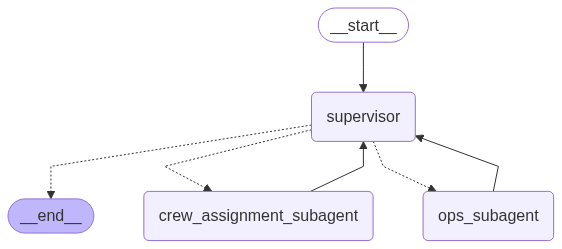

In [214]:
from IPython.display import display, Image

def show_graph(graph):
    """
    Display a LangGraph App or Graph as a Mermaid‐style PNG in Jupyter.
    """
    # If they passed an App, extract its Graph
    g = getattr(graph, "get_graph", lambda: graph)()
    png = g.draw_mermaid_png()
    display(Image(png))

show_graph(supervisor)

In [216]:
thread_id = uuid.uuid4()
question = "Check status flight_id UA123. Is it delayed? If yes, what is the impacted flight?"
config = {"configurable": {"thread_id": thread_id}}

result = supervisor.invoke({"messages": [HumanMessage(content=question)]}, config=config)
for message in result["messages"]:
    message.pretty_print()

================================ Human Message =================================

Check status flight_id UA123. Is it delayed? If yes, what is the impacted flight?
================================== Ai Message ==================================
Name: supervisor
Tool Calls:
  transfer_to_crew_assignment_subagent (call_4T4wvyTTNHwTS7xTgEpKKP55)
 Call ID: call_4T4wvyTTNHwTS7xTgEpKKP55
  Args:
================================= Tool Message =================================
Name: transfer_to_crew_assignment_subagent

Successfully transferred to crew_assignment_subagent
================================== Ai Message ==================================
Name: crew_assignment_subagent

Based on the status check, flight UA123 is delayed. The next connecting flight from its destination (SFO) is flight UA456, which becomes impacted by the delay. 

Returning the impacted flight details in the required JSON format:

[{
  "flight_id": "UA456",
  "impacted_crew_id": "UA123_crew",
  "replacement_crew_id"

In [217]:
thread_id = uuid.uuid4()
question = "Can you find available crews for impacted flights due to delayed flight UA123?"
config = {"configurable": {"thread_id": thread_id}}

result = supervisor.invoke({"messages": [HumanMessage(content=question)]}, config=config)
for message in result["messages"]:
    message.pretty_print()

================================ Human Message =================================

Can you find available crews for impacted flights due to delayed flight UA123?
================================== Ai Message ==================================
Name: supervisor
Tool Calls:
  transfer_to_crew_assignment_subagent (call_4Esz7KiI1w5dXlrThciDAmRW)
 Call ID: call_4Esz7KiI1w5dXlrThciDAmRW
  Args:
================================= Tool Message =================================
Name: transfer_to_crew_assignment_subagent

Successfully transferred to crew_assignment_subagent
================================== Ai Message ==================================
Name: crew_assignment_subagent

[
  {
    "flight_id": "UA456",
    "impacted_crew_id": "C001",
    "replacement_crew_id": null,
    "replacement_status": "no_qualified_spare"
  },
  {
    "flight_id": "UA456",
    "impacted_crew_id": "C002",
    "replacement_crew_id": "C010",
    "replacement_status": "legal"
  }
]
=================================

In [219]:
thread_id = uuid.uuid4()
question = "Can you book hotel and transport for stranded crews in ORD for flight UA123?"
config = {"configurable": {"thread_id": thread_id}}

result = supervisor.invoke({"messages": [HumanMessage(content=question)]}, config=config)
for message in result["messages"]:
    message.pretty_print()

================================ Human Message =================================

Can you book hotel and transport for stranded crews in ORD for flight UA123?
================================== Ai Message ==================================
Name: supervisor
Tool Calls:
  transfer_to_ops_subagent (call_ME36QJPvdO0VxLwCHnipJFHn)
 Call ID: call_ME36QJPvdO0VxLwCHnipJFHn
  Args:
================================= Tool Message =================================
Name: transfer_to_ops_subagent

Successfully transferred to ops_subagent
================================== Ai Message ==================================
Name: ops_subagent

[{
  "hotel_booking_reference": "ORD Airport Hotel",
  "transport_details": {
    "eta_minutes": 30,
    "mode": "shuttle"
  }
}]
================================== Ai Message ==================================
Name: ops_subagent

Transferring back to supervisor
Tool Calls:
  transfer_back_to_supervisor (fc0c2884-244d-453e-acf7-10e58402c373)
 Call ID: fc0c2884-244d-4

In [220]:
# %% [markdown]
# ## 🚀 Deploy with Gradio

# %%
# (1) install Gradio if you haven’t already
!pip install gradio --quiet

import gradio as gr

def interact_with_agent(prompt: str) -> str:
    """
    Send `prompt` into your LangGraph supervisor and return
    the concatenated agent messages as plain text.
    """
    # generate a fresh thread id so memory is scoped per-session
    thread_id = uuid.uuid4()
    config = {"configurable": {"thread_id": thread_id}}
    
    # invoke your compiled supervisor
    result = supervisor.invoke(
        {"messages": [HumanMessage(content=prompt)]},
        config=config
    )
    
    # join all messages into a single string
    return "\n".join(msg.content for msg in result["messages"])

# (2) define the Gradio interface
iface = gr.Interface(
    fn=interact_with_agent,
    inputs=gr.Textbox(lines=4, placeholder="Type your question about crew disruptions…"),
    outputs=gr.Textbox(label="Agent Response"),
    title="Crew Disruption Management Assistant",
    description="Ask about flight status, crew replacements, or accommodation/transport arrangements."
)

# (3) launch locally (add `share=True` if you want a public URL)
iface.launch(share=True)

/Users/andrewrafaeljames/Documents/Github/langchain-academy/lc-academy-env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


* Running on local URL:  http://127.0.0.1:7860
* Running on public URL: https://3d2e6525ea87fbf6b5.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Created dataset file at: .gradio/flagged/dataset1.csv


In [ ]:
# Check status flight_id UA123. Is it delayed? If yes, what is the impacted flight?
# Can you find available crews for impacted flights due to delayed flight UA123?
# Can you book hotel and transport for stranded crews in ORD for flight UA123?